Tim Smith

2019.09.21

# Control run Hovmöller plots 

## Showing zonal mean -vs- avg seasonal cycle for
- Precip
- P-E
- Surface temperature
- ...

In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import glob
import dask.array as da
from copy import deepcopy

import cftime # for converting the netcdf time to something nice

In [2]:
data_dir = '/Users/tim/work/results/acdc/half_ocean_newbucket_0qflux_control'
globname = data_dir + '/*/*.nc'
file_list = glob.glob(globname)
file_list = sorted(file_list)
ds_ctrl = xr.open_mfdataset(file_list,autoclose='true')

lat = ds_ctrl['lat'].values[:]
lon = ds_ctrl['lon'].values[:]
lev = ds_ctrl['pfull'].values[:]

/Users/tim/anaconda3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/Users/tim/anaconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


### First, remove first 8 years of spinup and convert time units to something nice for xarray

In [3]:
with xr.set_options(enable_cftimeindex=True):
    ds_ctrl = xr.open_mfdataset(file_list,autoclose='true',decode_times=False)

time0 = ds_ctrl['time']
# time2 = nc.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
#                             calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

time2 = cftime.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
                            calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

ds_ctrl['time'].values = time2

# Drop everything before the 9th year
ds_ctrl = ds_ctrl.where(ds_ctrl['time'].dt.year.isin(range(9,100)),drop=True)
#print(ds_ctrl)

### Convert units ...

In [4]:
# Precipitation to mm/day
ds_ctrl['precipitation'].values = 86400 * ds_ctrl['precipitation'].values
ds_ctrl['precipitation'].attrs['units']='mm/day'

# Latent heat flux to mm/day of evaporation
ds_ctrl['flux_lhe'].values = 1/28 * ds_ctrl['flux_lhe']
ds_ctrl['flux_lhe'].attrs['units']='mm/day'

### Now, very easily lets compute the seasonal cycle for all fields

In [5]:
ds_clim = ds_ctrl.groupby('time.month').mean('time')

Text(0.5,1,'Zonal mean precipitation')

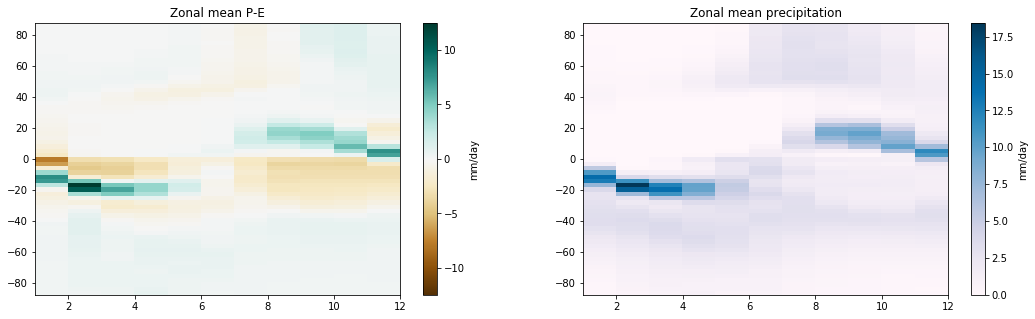

In [10]:
months = ds_clim['month']

plt.figure(figsize=(18,5))

# --- P - E
pme = ds_clim['precipitation'].mean('lon').T - ds_clim['flux_lhe'].mean('lon').T
color_lim = np.max(np.abs(pme.values))
plt.subplot(1,2,1)
plt.pcolormesh(months,lat,
               pme,
               cmap='BrBG',vmin=-color_lim,vmax=color_lim)
cbar = plt.colorbar()
cbar.set_label('mm/day')
plt.title('Zonal mean P-E')

# --- Precipitation
plt.subplot(1,2,2)
plt.pcolormesh(months,lat,
               ds_clim['precipitation'].mean('lon').T,
               cmap='PuBu')
cbar = plt.colorbar()
cbar.set_label('mm/day')
plt.title('Zonal mean precipitation')

Text(0.5,1,'Zonal mean surface specific humidity')

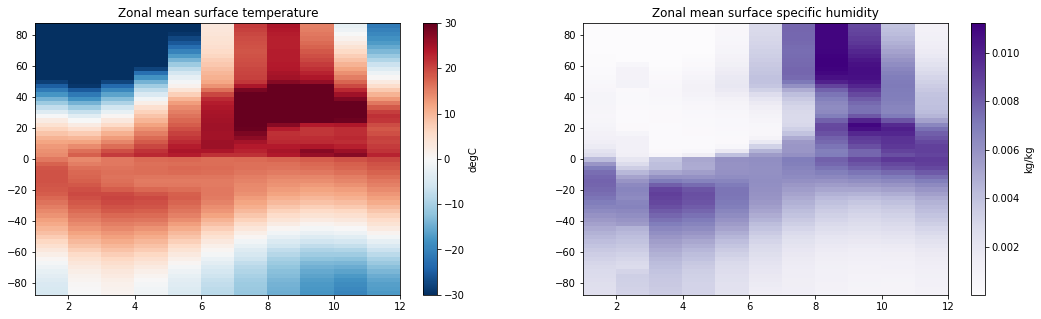

In [11]:
# --- Surface temperature
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.pcolormesh(months,lat,
               -273 + ds_clim['t_surf'].mean('lon').T,
               cmap='RdBu_r',vmin=-30,vmax=30)
cbar = plt.colorbar()
cbar.set_label('degC')
plt.title('Zonal mean surface temperature')

## --- Top of atmosphere flux
#plt.subplot(1,2,2)
#plt.pcolormesh(months,lat,
#               ds_clim['flux_sw'].mean('lon').T,
#               cmap='YlOrBr_r')
#cbar = plt.colorbar()
#cbar.set_label('W/m^2')
#plt.title('Zonal mean TOA')

# --- Surface specific humidity
plt.subplot(1,2,2)
plt.pcolormesh(months,lat,
              ds_clim['sphum'].mean('lon').isel(pfull=-1).T,
              cmap='Purples')
cbar=plt.colorbar()
cbar.set_label('kg/kg')
plt.title('Zonal mean surface specific humidity')

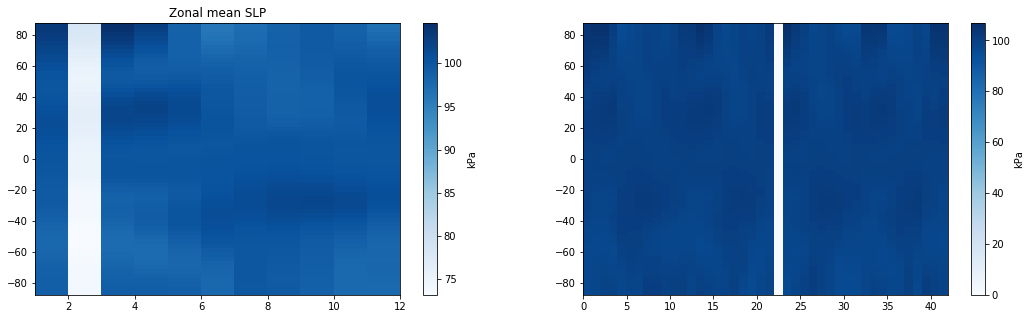

In [8]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.pcolormesh(months,lat,
               1/1000 * ds_clim['slp'].mean('lon').T,
               cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('kPa')
plt.title('Zonal mean SLP')

plt.subplot(1,2,2)
plt.pcolormesh(range(len(ds_ctrl['time'])),lat,
                1/1000*ds_ctrl['slp'].mean('lon').T,
                cmap='Blues')
cbar=plt.colorbar()
cbar.set_label('kPa')

In [9]:
#print(ds_ctrl)